# CNN mit "Fashion MNIST"

Zum Üben von CNN schauen wir uns ein Fallbeispiel an. Sehr häufig wird das Erkennen von handschriftlich geschriebenen Ziffern als Fallbeispiel genommen, das sogenannte **MNIST**-Beispiel.

Hier wollen wir uns ein ähnliches Beispiel anschauen, das jedoch umfangreicher und schwieriger ist, das sogenannte **Fashion-MNIST** von Zalando [Link](https://github.com/zalandoresearch/fashion-mnist).

Aufgabe ist es, anhand von 60000 Trainings- und 10000 schwarz-weißen Testbildern in Format 28x28 Pixeln einen Klassifikator zu trainieren, der in der Lage ist, ein Bild in eine von 10 Klassen für Modeartikeln einzuteilen.

ACHTUNG: das CNN-Modell ist sehr, sehr einfach und nicht gut aufgebaut...es ist Ihre Aufgabe, das zu optimieren!

## 1. Daten einlesen

In [1]:
# Einlesen der Standardbibliotheken
import numpy as np
import pandas as pd
import tensorflow as tf # neu: TensorFlow ist ein ML Framework von Google.

In [2]:
# Fashion_MNIST ist ein beispielhafter Datensatz der TensorFlow-Library, d.h. wir können den direkt einlesen
from tensorflow.keras.datasets import fashion_mnist
# wir teilen den Datensatz auf in Trainings- und Testdaten inkl. Label für Trainings- und Testdaten
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Statistiken zum Datensatz ausgeben
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Die Ausgaben zeigen, daß wir in der Trainingsmenge X_train 60'000 Bilder mit 28x28 Pixel haben und in der Testmenge 10'000.

Schauen wir uns die Labels an

In [4]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


Da wir für die Zielklassen nur Zahlen und keine Namen haben, speichern wir diese separat.

In [5]:
# definiere eine Liste mit den verschiedenen Zielklassen
class_names = ['T-shirt/ Top',
               'Hose',
               'Pullover',
               'Kleid',
               'Mantel',
               'Sandale',
               'Hemd',
               'Sneaker',
               'Tasche',
               'Stiefel']

Wir lassen in diesem Notebook Image Augmentation aus. In diesem Notebook geht es mehr darum, daß Sie mit den Hyperparametern experimentieren und sehen, wie die Struktur eines CNN Auswirkungen auf die Genauigkeit des Lernens hat.

Deshalb normalisieren wir nur die Bilder als einzige "Augmentation".

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Als letzten Schritt bauen wir noch schnell das Datenset um.
Wir haben folgende Struktur von X_Train und X_Test:
Anzahl Bilder * x_pixel * y_Pixel.

Wir wollen eine zusätzliche Ebene für den grauen Farbkanal haben:
Anzahl Bilder * x_pixel * y_Pixel * Farbkanal


In [7]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

In [8]:
# Statistiken zum Datensatz ausgeben
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


Wir sehen das Ergebnis des Reshaping im Vergleich zum ersten Shaping:
* X_train ist jetzt (60000,28,28,1) zu vorher (60000,28,28).
* Y_train ist jetzt (10000, 28, 28, 1) zu vorher (10000, 28, 28).

Schauen wir uns nun die Bilder mal an. Und geben dazu das Label aus

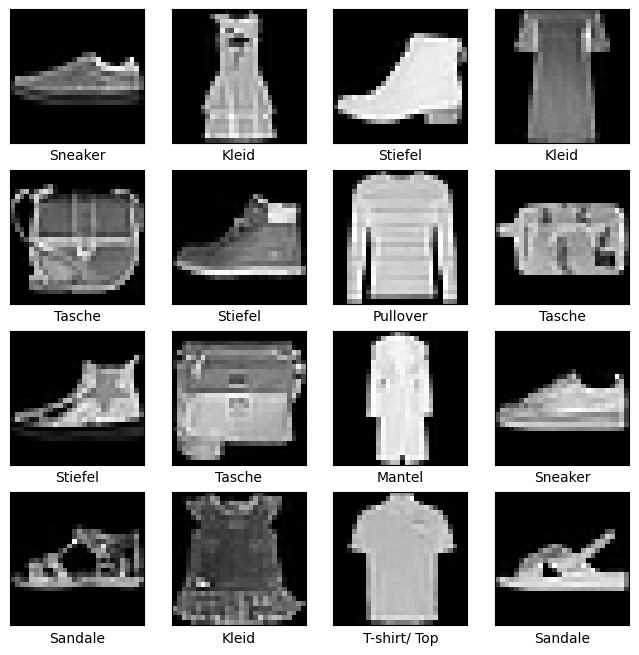

In [9]:
import matplotlib.pyplot as plt

number_cols = 4 # Anzahl der Spalten für das Bild
number_rows = 4 # Anzahl der Reihen für das Bild
run_index = 0 # durchlaufende Index für einzelne Bilder, startet mit 0 und geht bis 4*4 = 16

plt.figure(1 , figsize = (8 , 8))

for i in range(number_cols * number_rows):
  run_index += 1 #erhöhe den durchlaufenden Index
  # definiere ein Teilbild
  cur_plot = plt.subplot(number_cols, number_rows, run_index)
  plt.xticks([]) # keine Beschriftung x-Achse
  plt.yticks([]) # keine Beschriftung y-Achse
  plt.grid(False) # kein Grid/ Rahmen zeichnen

  pic_index = np.random.randint(0, 60000) # wähle ein zufälliges Bild
  # lade und stelle ein Bild dar mit dem gewählten zufälligen Index
  plt.imshow(X_train[pic_index], cmap=plt.get_cmap('gray'))
  # schreib den Wert des Labels für das Bild als Wert unter das Bild
  plt.xlabel(class_names[y_train[pic_index]])
plt.show()

## 2. Machine Learning: Wir bauen ein CNN

In [10]:
from tensorflow import keras   # Keras als Schnittstelle zu den "komplizierteren Umfängen"
from keras import layers
from keras import Model

# wie oben gezeigt, hat jedes Bild 28x28 Pixel.
# Da wir die Bilder nur in Graustaufen haben, gibt es zusätzlich nur 1 Kanal.
INPUT_SHAPE = (28,28, 1)

num_target_classes = 10 # wir haben 10 Zielklassen

# wir bauen den Input Layer. Jeder Pixel ist ein Input für das CNN.
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

# wir bauen den ersten Bildverarbeitungs-Layer. Erst Faltung, dann Pooling, dann Droput
conv1 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2)) (conv1)
drop1 = tf.keras.layers.Dropout(0.5) (pool1)

# wir bauen den 2. Bildverarbeitungs-Layer. Erst Faltung, dann Pooling, dann Droput
conv2 = tf.keras.layers.Conv2D(64,
                               kernel_size=(3, 3),
                               activation='relu',
                               padding='same') (drop1)

pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
#drop2 = tf.keras.layers.Dropout(0.5) (pool2)  # vor Flatten nimmt man kein Pooling.

# nach dem 2. Bildverarbeitungs-Layer geben wir die Daten in ein "normales" CNN rein.
flat = tf.keras.layers.Flatten()(pool2)

# hier der erste Hidden Layer des CNN
hidden1 = tf.keras.layers.Dense(256, activation='relu')(flat)
drop3 = tf.keras.layers.Dropout(rate=0.5)(hidden1)

# hier der zweite Hidden Layer des CNN
hidden2 = tf.keras.layers.Dense(64, activation='relu')(drop3)
drop4 = tf.keras.layers.Dropout(rate=0.5)(hidden2)

# und hier gehts raus aus dem CNN.
# Wichtig ist die Wahl des Dense Layers und der Softmax-Aktivierungsfunktion.
# Diese brauchen wir, da wir mit dieser das Ergebnis klassifizieren können.
# Als Ergebnis erhalten wir für jede mögliche Zielklasse einen Wert.
# Out erhält dann den Wert, der die höchste Wahrscheinlichkeit hat.
out = tf.keras.layers.Dense(num_target_classes, activation='softmax')(drop4)

# jetzt speichern wir die ganze Struktur in ein Modell
model = tf.keras.Model(inputs=inp, outputs=out)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 857,738 (3.27 MB)

 Trainable params: 857,738 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

Nachdem wir das Modell gebaut haben, definieren wir jetzt die Hyperparameter

* Batch_size: wie viele Samples werden aus der Trainingsmenge genommen bevor die Gewichte und Bias des Modells angepaßt werden. Im unteren Fall heißt das, nach 256 Bildern passen wir die Gewichte an.
* Epochen: wie viele Durchläufe durch das gesamte Datenset werden gemacht.
* Learning_rate: Geschwindigkeit mit der das Modell lernt. Genauer gesagt stellt es die Schrittweite dar, die bei jeder Iteration gegangen wird, um das Minimum der Loss-Funktion zu erreichen.
* Optimizer: Algorithmus der eingesetzt wird, um die Gewichte und Bias so zu reduzieren, daß die Loss-Funktion minimiert wird.

Diese Parameter ermöglichen deutliche Verbesserungen des Ergebnisses und stehen auch miteinander in Verbindung (bspw. small batch size sollte mit niedriger Lernrate kombiniert werden).

Nachdem wir das gemacht haben, starten wir das Trainieren des Models.

In [12]:
# Hyperparameter definieren
BATCH_SIZE = 32 # 32 ist eine faustregel für gute Batchsize
EPOCHS = 50

# definieren des Optimierers und der Lernrate.
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [13]:
model.compile(optimizer=optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Jetzt definieren wir die Trainingsparameter

In [14]:
history = model.fit(x=X_train,  # zuweisung trainingsdaten
                    y= y_train, # zuweisung label für die trainingsdaten
                    validation_data = (X_test, y_test),  # an welchen daten wird modell validiert
                    batch_size=BATCH_SIZE, # Definition Batch size
                    epochs = EPOCHS # definition Anzahl Trainingsdurchläufe
                    )

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6578 - loss: 0.9557 - val_accuracy: 0.8601 - val_loss: 0.3897
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8461 - loss: 0.4460 - val_accuracy: 0.8820 - val_loss: 0.3228
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8708 - loss: 0.3807 - val_accuracy: 0.8950 - val_loss: 0.2954
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8835 - loss: 0.3354 - val_accuracy: 0.8941 - val_loss: 0.2864
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8888 - loss: 0.3197 - val_accuracy: 0.9068 - val_loss: 0.2582
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8967 - loss: 0.3001 - val_accuracy: 0.9028 - val_loss: 0.2640
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9011 - loss: 0.2858 - val_accuracy: 0.9096 - val_loss: 0.2518
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9003 - loss: 0.2801 -

Nach dem Training schauen wir uns jetzt an, wie hoch die Genauigkeit ist.

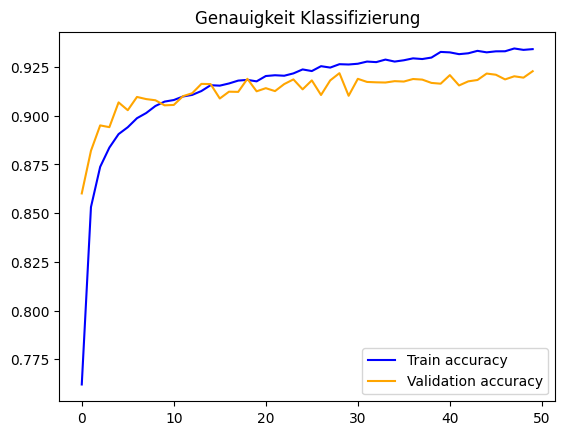

In [15]:
# Plotte Genauigkeit
plt.title('Genauigkeit Klassifizierung')
plt.plot(history.history['accuracy'], color='blue', label='Train accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation accuracy')
plt.legend()
plt.show()

# 3. Testen des Modells

## 3.1. Testen eines einzelnen Bildes

In [16]:
def classify_pic(samplePicture, picindex):

  sample_pic_aufbereitet = samplePicture.reshape (1, 28, 28, 1)
  predicted_model = model.predict(sample_pic_aufbereitet)

  temp_picture = samplePicture.reshape(28,28) # wir löschen den Schwarz-weiß Kanal fürs Anzeigen des Bildes

  plt.imshow(temp_picture)

  plt.xlabel(class_names[y_test[picindex]])

  plt.show()

  print("Klasse vorhergesagt: {}".format(class_names[np.argmax(predicted_model[0])]))
  print("Gesamte Wahrscheinlichkeiten:")

  plt.bar(range(10), predicted_model[0])
  plt.grid(False)
  x_vals = range(0, len(class_names))
  plt.xticks(x_vals, class_names, rotation=45)
  plt.xticks(range(10))
  plt.yticks([])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


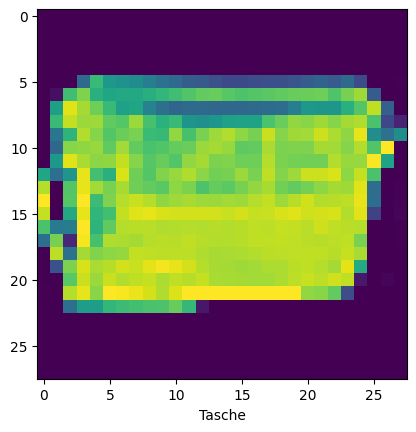

Klasse vorhergesagt: Tasche
Gesamte Wahrscheinlichkeiten:


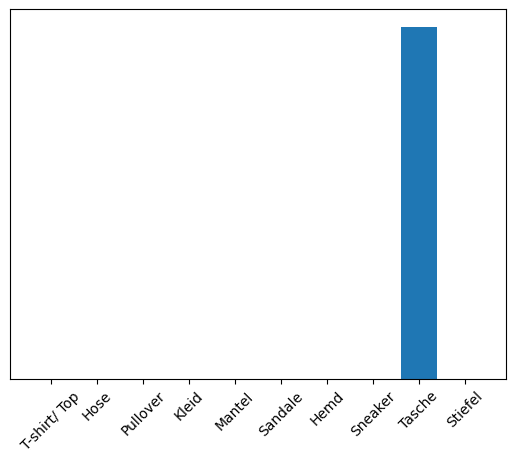

In [17]:
classify_pic(X_test[56], 56)

## 3.2 Genauigkeit des gesamten Modells anhand Testdaten

In [18]:
from sklearn.metrics import classification_report

loss_model, accuracy_model = model.evaluate(X_test, y_test)
print('Test accuracy :', accuracy_model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9265 - loss: 0.2610
Test accuracy : 0.9228000044822693


Schauen wir uns im Detail an, wie gut das Modell ist anhand zweier weiteren Größen:
* Precision: wie viele der vorhergesagten Labels waren richtig (bspw. "Hose" vorhergesagt und war dann auch "Hose")
* Recall: wie viele Elemente wurden korrekt vorhergesagt?

Diese beiden Größen werden oft analysisert, weil sie detaillierter Auskunft über die Güte des Modells geben.

In [19]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool, target_names=class_names))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

T-shirt/ Top       0.86      0.89      0.87      1000
        Hose       0.99      0.99      0.99      1000
    Pullover       0.88      0.89      0.88      1000
       Kleid       0.90      0.96      0.93      1000
      Mantel       0.89      0.85      0.87      1000
     Sandale       0.99      0.99      0.99      1000
        Hemd       0.80      0.75      0.77      1000
     Sneaker       0.95      0.98      0.97      1000
      Tasche       0.99      0.99      0.99      1000
     Stiefel       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



--------------------------------------------------------------------------------------------------

Nachdem Sie jetzt einen gesamten Durchlauf gesehen haben, sind Sie an der Reihe!

Probieren Sie verschiedene CNN-Strukturen aus: wie ändert sich dabei die Genauigkeit des Modells?

* Anpassungen der bestehenden Conv2D-Faltungen: Anzahl Filter (erste Zahl), Kernel, Padding, Aktivierungsfunktionen
* Mehrere neue Faltungen (Conv2D)
* MaxPooling2D: Größe des Pooling
* Dropout: Prozentsatz
* Anpassungen der bestehenden Dense-Layers
* Neue Dense-Layers

Probieren Sie verschiedene Hyperparameter aus: wie ändert sich dabei die Genauigkeit des Modells?
* BATCH_SIZE
* EPOCHS
* LEARNING_RATE